In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

# Import data

In [2]:
#dataset = pd.read_csv('parsed_dataset.csv', sep='\t', converters={'Tags': lambda x: eval(x)})
%store -r dataset
dataset

,Body,Tags
0,I have a UIImageView that I have already set a...,[iphone]
2,The requirements I'm up againstAbout 12 people...,"[c#, winforms]"
4,I am using the xml-simple gem inside a rake ta...,"[ruby, xml]"
5,I'm trying to get a PHP array that includes a ...,[php]
7,I have done some Google searching and found th...,"[python, sql, django]"
...,...,...
99706,So I'm trying to get rid of my std::vector's b...,[c++]
99707,Is it possible to have a singleton in a factor...,[java]
99708,I was wondering if there is some option to kee...,"[c#, visual-studio-2008]"
99709,"I have found the ""Getting Started"" documents f...",[iphone]


In [132]:
class Opts:
    use_hashing = False
    select_chi2 = 500
    print_top10 = True
    print_cm = False
    print_report = True
    
opts = Opts()

In [ ]:
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

def benchmark(clf, clf_name):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    f1_micro = metrics.f1_score(y_test, pred, average='micro')
    print("f1-score (micro):   %0.3f" % f1_micro)
    f1_macro = metrics.f1_score(y_test, pred, average='macro')
    print("f1-score (micro):   %0.3f" % f1_macro)

    coef = None
    if hasattr(clf, 'estimators_') and all(hasattr(estimator, 'coef_') for estimator in clf.estimators_):
        coef = np.concatenate([estimator.coef_ for estimator in clf.estimators_])
    elif hasattr(clf, 'coef_'):
        coef = clf.coef_
        
    if type(coef) != type(None):
        print("dimensionality: %d" % coef.shape[1])
        print("density: %f" % density(coef))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(coef[i])[-10:]
                print("%s: %s" % (label, " ".join(feature_names[top10])))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names,
                                            zero_division=0))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.multilabel_confusion_matrix(y_test, pred))

    print()
    return clf_name, score, f1_micro, f1_macro, train_time, test_time

In [3]:
def get_preprocessing_pipeline(select_chi2 = None):
    return Pipeline([
        ('tf-idf', TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')),
        ('feature-reduction', SelectKBest(chi2, k=select_chi2) if select_chi2 else 'passthrough')
    ])

In [173]:
def evaluate_models(X, y, select_chi2 = 500, print_top10 = True, print_cm = False, print_report = True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    mlb = MultiLabelBinarizer().fit(y.to_list())
    y_train = mlb.transform(y_train)
    y_test = mlb.transform(y_test)
    target_names = mlb.classes_

    preprocess_pipeline = get_preprocessing_pipeline(select_chi2)
    X_train = preprocess_pipeline.fit_transform(X_train, y_train)
    X_test = preprocess_pipeline.transform(X_test)
 
    results = []
    for clf, name in (
            (RidgeClassifier(tol=1e-2, solver="sag", random_state=1), "Ridge Classifier"),
            (OneVsRestClassifier(Perceptron(max_iter=50, n_jobs=-1, random_state=2), n_jobs=-1), "Perceptron"),
            (OneVsRestClassifier(PassiveAggressiveClassifier(max_iter=50, n_jobs=-1, random_state=3)),
             "Passive-Aggressive"),
            (KNeighborsClassifier(n_neighbors=10, n_jobs=-1), "kNN"),
            (RandomForestClassifier(n_jobs=-1, random_state=5), "Random forest")):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(OneVsRestClassifier(LinearSVC(penalty=penalty, dual=False,
                                           tol=1e-3, random_state=5)), f'LinearSVC {penalty.upper()}'))

        # Train SGD model
        results.append(benchmark(OneVsRestClassifier(SGDClassifier(alpha=.0001, max_iter=50,
                                               penalty=penalty, n_jobs=-1, random_state=3)), 'SGD Classifier'))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    name = "Elastic-Net penalty"
    print(name)
    results.append(benchmark(OneVsRestClassifier(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty="elasticnet", n_jobs=-1, random_state=5)), name))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(OneVsRestClassifier(MultinomialNB(alpha=.01)), 'Mutltinomial NB'))
    results.append(benchmark(OneVsRestClassifier(BernoulliNB(alpha=.01)), 'Bernoulli NB'))
    results.append(benchmark(OneVsRestClassifier(ComplementNB(alpha=.1)), 'Complement NB'))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
      ('feature_selection', SelectFromModel(OneVsRestClassifier(LinearSVC(penalty="l1", dual=False,
                                                      tol=1e-3, random_state=4)))),
      ('classification', OneVsRestClassifier(LinearSVC(penalty="l2", random_state=8)))]), 'SVC L1 feature select'))

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(6)]

    clf_names, score, f1_micro, f1_macro, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(14, 8))
    plt.title("Score")
    plt.barh(indices, score, .1, label="score", color='navy')
    plt.barh(indices + .2, f1_micro, .1, label="F1 (micro)", color='b')
    plt.barh(indices + .4, f1_macro, .1, label="F1 (macro)", color='m')
    plt.barh(indices + .6, training_time, .1, label="training time",
             color='c')
    plt.barh(indices + .8, test_time, .1, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()

    result_df = pd.DataFrame(np.array(results[1:]).T, index=results[0], columns=['Score', 'F1 micro', 'F1 macro', 'Training time', 'Testing time'])
    display(result_df)

    print('Best score algorithm:')
    print(f'{result_df["Score"].idxmax()}: {result_df["Score"].max()}')
    print('_' * 80)
    print('Best f1 micro algorithm:')
    print(f'{result_df["F1 micro"].idxmax()}: {result_df["F1 micro"].max()}')
    print('_' * 80)
    print('Best f1 macro algorithm:')
    print(f'{result_df["F1 macro"].idxmax()}: {result_df["F1 macro"].max()}')
    print('_' * 80)
    print('Fastest training algorithm:')
    print(f'{result_df["Training time"].idxmin()}: {result_df["Training time"].min()}')
    print('_' * 80)
    print('Fastest testing algorithm:')
    print(f'{result_df["Testing time"].idxmin()}: {result_df["Testing time"].min()}')
    print('_' * 80)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(random_state=1, solver='sag', tol=0.01)


/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 2.549s
test time:  0.003s
accuracy:   0.250
f1-score (micro):   0.494
f1-score (micro):   0.456
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: forms winforms linq submitchanges datagridview wcf xmldocument runat assembly net
ajax: val alert innerhtml success updatepanel xmlhttp xhr responsetext xmlhttprequest ajax
algorithm: char elements vector route range dimensional arr formula algorithms algorithm
android: apk mainactivity imageview settext intent oncreate activity findviewbyid toast android
arrays: elements numpy endl print var int dimensional arr arrays array
asp.net: controls web updatepanel iis webforms runat postback gridview aspx asp
asp.net-mvc: modelstate redirecttoaction maproute actionlink htmlhelper selectlist beginform viewdata actionresult mvc
c: pointer sizeof unsigned char struct typedef gcc malloc stdio printf
c#: net datagridview winforms string submitchanges linq public ienumerable xmldocument tolist
c++: compiler pointer const 

train time: 1.004s
test time:  0.010s
accuracy:   0.310
f1-score (micro):   0.559
f1-score (micro):   0.509
dimensionality: 500
density: 0.892080
top 10 keywords per class:
.net: wsdl route datagridview wcf webservices designer delegate runat assembly net
ajax: xhr div val innerhtml content xmlhttp success xmlhttprequest responsetext ajax
algorithm: arr 2008 1px 5px branches manytomanyfield grid route algorithms algorithm
android: savedinstancestate onclicklistener mainactivity linearlayout edittext toast oncreate findviewbyid apk android
arrays: join 2005 align apple endl print arr dimensional arrays array
asp.net: asmx iis webmethod runat updatepanel webforms gridview aspx postback asp
asp.net-mvc: redirecttoaction actionlink modelstate htmlhelper maproute selectlist actionresult viewdata beginform mvc
c: char macro svnkit struct gcc typedef scanf malloc printf stdio
c#: orderby threadpool public winform linq datagridview ienumerable submitchanges xmldocument tolist
c++: const hwnd m

train time: 16.167s
test time:  1.152s
accuracy:   0.308
f1-score (micro):   0.516
f1-score (micro):   0.450
classification report:
                    precision    recall  f1-score   support

              .net       0.55      0.21      0.31      1303
              ajax       0.74      0.15      0.25       187
         algorithm       0.70      0.28      0.40       182
           android       0.90      0.71      0.79       446
            arrays       0.54      0.17      0.26       189
           asp.net       0.78      0.47      0.58       972
       asp.net-mvc       0.87      0.39      0.54       315
                 c       0.51      0.25      0.34       379
                c#       0.53      0.25      0.34      2197
               c++       0.69      0.35      0.46       983
               css       0.84      0.55      0.66       430
          database       0.50      0.06      0.10       344
            django       0.93      0.66      0.77       189
           eclipse       0.

train time: 0.940s
test time:  0.009s
accuracy:   0.209
f1-score (micro):   0.405
f1-score (micro):   0.308
dimensionality: 500
density: 0.831560
top 10 keywords per class:
.net: threadpool designer delegate wsdl xmldocument webservices wcf runat assembly net
ajax: img request updatepanel innerhtml success xhr responsetext xmlhttp xmlhttprequest ajax
algorithm: intent 5px z0 width arrays branches manytomanyfield route algorithms algorithm
android: onclicklistener edittext savedinstancestate textview toast oncreate findviewbyid activity intent android
arrays: admin bash elements endl var apple arr arrays dimensional array
asp.net: controls webmethod iis webforms updatepanel gridview postback runat aspx asp
asp.net-mvc: modelstate htmlhelper selectlist redirecttoaction beginform actionlink maproute actionresult viewdata mvc
c: char unsigned gcc struct typedef sizeof scanf stdio malloc printf
c#: iqueryable linq winform orderby winforms submitchanges xmldocument tolist datagridview ienume

train time: 1.187s
test time:  0.009s
accuracy:   0.248
f1-score (micro):   0.478
f1-score (micro):   0.389
dimensionality: 500
density: 0.024480
top 10 keywords per class:
.net: iframe ienumerable hwnd htmlhelper indexpath za datagridview wcf assembly net
ajax: za iframe iis image imageview img import php xmlhttp ajax
algorithm: iframe ienumerable id hwnd htmlhelper html5 indexpath za algorithms algorithm
android: drawable activity textview savedinstancestate toast apk findviewbyid intent oncreate android
arrays: iis iframe ienumerable id hwnd htmlhelper jar za arrays array
asp.net: web controls iis webforms updatepanel runat gridview aspx postback asp
asp.net-mvc: image iis action route controller beginform actionlink actionresult viewdata mvc
c: image imageview img iis struct gcc scanf stdio malloc printf
c#: void string public winform property linq xmldocument winforms datagridview ienumerable
c++: char const iostream endl mfc stl cpp cout boost std
css: border div background webki

train time: 0.292s
test time:  0.074s
accuracy:   0.031
f1-score (micro):   0.082
f1-score (micro):   0.079
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: public control web gt lt windows class string application net
ajax: php request lt javascript url gt jquery function page ajax
algorithm: elements strings function string gt int lt array algorithms algorithm
android: lt public application id layout view intent activity app android
arrays: var elements arr function string lt arrays int gt array
asp.net: aspx gt application lt control server page web net asp
asp.net-mvc: model page gt lt action view controller net asp mvc
c: array lt gcc gt struct include function printf char int
c#: control windows int application class public lt gt net string
c++: void include char const function class gt std lt int
css: page height html style width background gt lt div css
database: application query db server mysql databases tables sql table database
django: class foreignkey

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.350s
test time:  0.094s
accuracy:   0.163
f1-score (micro):   0.500
f1-score (micro):   0.492
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: server web public windows gt lt string class application net
ajax: var html javascript lt gt jquery url page function ajax
algorithm: class input int string function algorithms gt array lt algorithm
android: view id string class public void lt gt app android
arrays: var elements class string arrays function int lt gt array
asp.net: string control gt lt application server page web net asp
asp.net-mvc: web action page view lt gt controller asp net mvc
c: struct string include void printf lt char gt function int
c#: text int void application public net lt gt class string
c++: public string include void std function class int gt lt
css: style page width class text html div lt gt css
database: select mysql db query application tables server sql table database
django: html lt request gt def py class models model dja

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.294s
test time:  0.078s
accuracy:   0.007
f1-score (micro):   0.280
f1-score (micro):   0.267
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: manytomanyfield svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive
ajax: manytomanyfield svnadmin verbose_name activesheet pyclass render_to_response is_valid on_delete svnkit subversive
algorithm: manytomanyfield svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive
android: edittext mainactivity savedinstancestate apk setcontentview wrap_content layout_height layout_width linearlayout match_parent
arrays: manytomanyfield svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive
asp.net: svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive updatepanel
asp.net-mvc: subversive actionresult actionlink viewdata redirecttoaction modelstate b

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


                    precision    recall  f1-score   support

              .net       0.21      0.79      0.34      1303
              ajax       0.06      0.95      0.12       187
         algorithm       0.07      0.81      0.12       182
           android       0.28      0.91      0.43       446
            arrays       0.07      0.91      0.14       189
           asp.net       0.26      0.86      0.40       972
       asp.net-mvc       0.15      0.89      0.26       315
                 c       0.12      0.74      0.21       379
                c#       0.32      0.80      0.46      2197
               c++       0.26      0.76      0.38       983
               css       0.23      0.95      0.37       430
          database       0.12      0.86      0.20       344
            django       0.16      0.89      0.28       189
           eclipse       0.09      0.91      0.17       166
             excel       0.21      0.95      0.35       158
              html       0.20      0.85

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


train time: 6.809s
test time:  0.010s
accuracy:   0.267
f1-score (micro):   0.512
f1-score (micro):   0.459
classification report:
                    precision    recall  f1-score   support

              .net       0.65      0.18      0.29      1303
              ajax       0.60      0.32      0.41       187
         algorithm       0.65      0.20      0.30       182
           android       0.96      0.67      0.79       446
            arrays       0.56      0.26      0.36       189
           asp.net       0.79      0.47      0.59       972
       asp.net-mvc       0.88      0.53      0.66       315
                 c       0.76      0.22      0.34       379
                c#       0.63      0.16      0.26      2197
               c++       0.85      0.33      0.47       983
               css       0.72      0.40      0.51       430
          database       0.14      0.00      0.01       344
            django       0.86      0.64      0.74       189
           eclipse       0.8

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


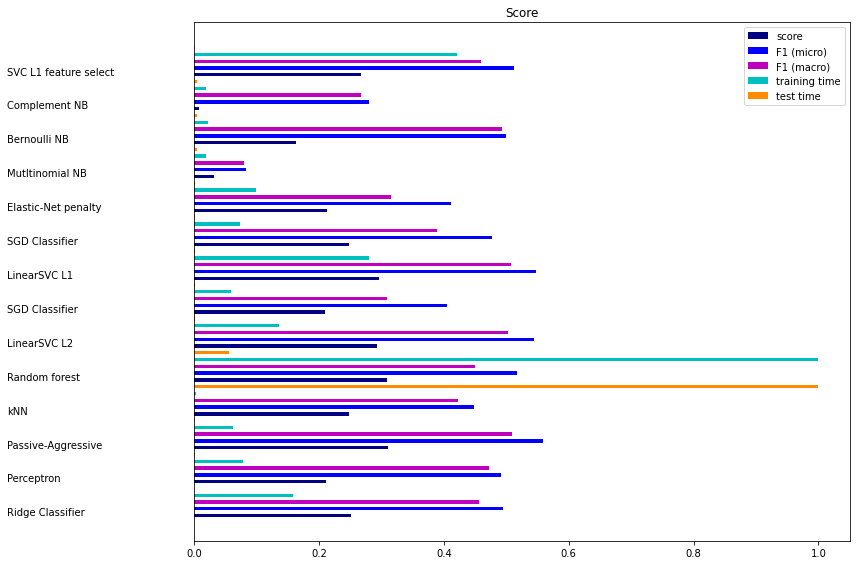

,Score,F1 micro,F1 macro,Training time,Testing time
Ridge Classifier,0.250398,0.493955,0.455529,2.549496,0.003106
Perceptron,0.211437,0.491479,0.472884,1.260196,0.030128
Passive-Aggressive,0.310297,0.559196,0.509434,1.003862,0.009768
kNN,0.248012,0.448483,0.422292,0.051557,20.718893
Random forest,0.307978,0.516489,0.450219,16.167473,1.152008
LinearSVC L2,0.292937,0.543465,0.502656,2.182616,0.009628
SGD Classifier,0.208654,0.404518,0.308368,0.939772,0.009313
LinearSVC L1,0.295521,0.548138,0.507160,4.529157,0.009784
SGD Classifier,0.247880,0.477601,0.389154,1.186613,0.009451
Elastic-Net penalty,0.212430,0.411283,0.315061,1.594654,0.009278


Best score algorithm:
Passive-Aggressive: 0.3102968460111317
________________________________________________________________________________
Best f1 micro algorithm:
Passive-Aggressive: 0.5591964337405199
________________________________________________________________________________
Best f1 macro algorithm:
Passive-Aggressive: 0.5094344767004182
________________________________________________________________________________
Fastest training algorithm:
kNN: 0.051557064056396484
________________________________________________________________________________
Fastest testing algorithm:
Ridge Classifier: 0.003106355667114258
________________________________________________________________________________


In [174]:
evaluate_models(dataset['Body'], dataset['Tags'])

In [164]:
import nltk
from nltk.stem import WordNetLemmatizer

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')
tokens = dataset['Body'].str.lower().map(tokenizer.tokenize)
tokens

0        [i, have, a, uiimageview, that, i, have, alrea...
2        [the, requirements, i, m, up, againstabout, pe...
4        [i, am, using, the, xml, simple, gem, inside, ...
5        [i, m, trying, to, get, a, php, array, that, i...
7        [i, have, done, some, google, searching, and, ...
                               ...                        
99706    [so, i, m, trying, to, get, rid, of, my, std, ...
99707    [is, it, possible, to, have, a, singleton, in,...
99708    [i, was, wondering, if, there, is, some, optio...
99709    [i, have, found, the, getting, started, docume...
99710    [i, have, a, d, area, with, dots, distributed,...
Name: Body, Length: 75460, dtype: object

In [165]:
wnl = WordNetLemmatizer()
lem_tokens = tokens.map(lambda x: [wnl.lemmatize(w) for w in x])
lem_tokens

0        [i, have, a, uiimageview, that, i, have, alrea...
2        [the, requirement, i, m, up, againstabout, peo...
4        [i, am, using, the, xml, simple, gem, inside, ...
5        [i, m, trying, to, get, a, php, array, that, i...
7        [i, have, done, some, google, searching, and, ...
                               ...                        
99706    [so, i, m, trying, to, get, rid, of, my, std, ...
99707    [is, it, possible, to, have, a, singleton, in,...
99708    [i, wa, wondering, if, there, is, some, option...
99709    [i, have, found, the, getting, started, docume...
99710    [i, have, a, d, area, with, dot, distributed, ...
Name: Body, Length: 75460, dtype: object

Extracting features from the training data using a sparse vectorizer
done in 2.314898s at 19.808MB/s
n_samples: 60368, n_features: 175167

Extracting features from the test data using the same vectorizer
done in 0.534521s at 21.396MB/s
n_samples: 15092, n_features: 175167

Extracting 500 best features by a chi-squared test
done in 0.282929s

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(random_state=1, solver='sag', tol=0.01)


/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:729: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 2.445s
test time:  0.003s
accuracy:   0.250
f1-score (micro):   0.494
f1-score (micro):   0.456
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: forms winforms linq submitchanges datagridview wcf xmldocument runat assembly net
ajax: val alert innerhtml success updatepanel xmlhttp xhr responsetext xmlhttprequest ajax
algorithm: char elements vector route range dimensional arr formula algorithms algorithm
android: apk mainactivity imageview settext intent oncreate activity findviewbyid toast android
arrays: elements numpy endl print var int dimensional arr arrays array
asp.net: controls web updatepanel iis webforms runat postback gridview aspx asp
asp.net-mvc: modelstate redirecttoaction maproute actionlink htmlhelper selectlist beginform viewdata actionresult mvc
c: pointer sizeof unsigned char struct typedef gcc malloc stdio printf
c#: net datagridview winforms string submitchanges linq public ienumerable xmldocument tolist
c++: compiler pointer const 

train time: 1.001s
test time:  0.010s
accuracy:   0.310
f1-score (micro):   0.559
f1-score (micro):   0.509
dimensionality: 500
density: 0.892080
top 10 keywords per class:
.net: wsdl route datagridview wcf webservices designer delegate runat assembly net
ajax: xhr div val innerhtml content xmlhttp success xmlhttprequest responsetext ajax
algorithm: arr 2008 1px 5px branches manytomanyfield grid route algorithms algorithm
android: savedinstancestate onclicklistener mainactivity linearlayout edittext toast oncreate findviewbyid apk android
arrays: join 2005 align apple endl print arr dimensional arrays array
asp.net: asmx iis webmethod runat updatepanel webforms gridview aspx postback asp
asp.net-mvc: redirecttoaction actionlink modelstate htmlhelper maproute selectlist actionresult viewdata beginform mvc
c: char macro svnkit struct gcc typedef scanf malloc printf stdio
c#: orderby threadpool public winform linq datagridview ienumerable submitchanges xmldocument tolist
c++: const hwnd m

train time: 16.614s
test time:  1.161s
accuracy:   0.308
f1-score (micro):   0.516
f1-score (micro):   0.450
classification report:
                    precision    recall  f1-score   support

              .net       0.55      0.21      0.31      1303
              ajax       0.74      0.15      0.25       187
         algorithm       0.70      0.28      0.40       182
           android       0.90      0.71      0.79       446
            arrays       0.54      0.17      0.26       189
           asp.net       0.78      0.47      0.58       972
       asp.net-mvc       0.87      0.39      0.54       315
                 c       0.51      0.25      0.34       379
                c#       0.53      0.25      0.34      2197
               c++       0.69      0.35      0.46       983
               css       0.84      0.55      0.66       430
          database       0.50      0.06      0.10       344
            django       0.93      0.66      0.77       189
           eclipse       0.

train time: 0.961s
test time:  0.009s
accuracy:   0.209
f1-score (micro):   0.405
f1-score (micro):   0.308
dimensionality: 500
density: 0.831560
top 10 keywords per class:
.net: threadpool designer delegate wsdl xmldocument webservices wcf runat assembly net
ajax: img request updatepanel innerhtml success xhr responsetext xmlhttp xmlhttprequest ajax
algorithm: intent 5px z0 width arrays branches manytomanyfield route algorithms algorithm
android: onclicklistener edittext savedinstancestate textview toast oncreate findviewbyid activity intent android
arrays: admin bash elements endl var apple arr arrays dimensional array
asp.net: controls webmethod iis webforms updatepanel gridview postback runat aspx asp
asp.net-mvc: modelstate htmlhelper selectlist redirecttoaction beginform actionlink maproute actionresult viewdata mvc
c: char unsigned gcc struct typedef sizeof scanf stdio malloc printf
c#: iqueryable linq winform orderby winforms submitchanges xmldocument tolist datagridview ienume

train time: 1.190s
test time:  0.009s
accuracy:   0.248
f1-score (micro):   0.478
f1-score (micro):   0.389
dimensionality: 500
density: 0.024480
top 10 keywords per class:
.net: iframe ienumerable hwnd htmlhelper indexpath za datagridview wcf assembly net
ajax: za iframe iis image imageview img import php xmlhttp ajax
algorithm: iframe ienumerable id hwnd htmlhelper html5 indexpath za algorithms algorithm
android: drawable activity textview savedinstancestate toast apk findviewbyid intent oncreate android
arrays: iis iframe ienumerable id hwnd htmlhelper jar za arrays array
asp.net: web controls iis webforms updatepanel runat gridview aspx postback asp
asp.net-mvc: image iis action route controller beginform actionlink actionresult viewdata mvc
c: image imageview img iis struct gcc scanf stdio malloc printf
c#: void string public winform property linq xmldocument winforms datagridview ienumerable
c++: char const iostream endl mfc stl cpp cout boost std
css: border div background webki

train time: 0.290s
test time:  0.074s
accuracy:   0.031
f1-score (micro):   0.082
f1-score (micro):   0.079
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: public control web gt lt windows class string application net
ajax: php request lt javascript url gt jquery function page ajax
algorithm: elements strings function string gt int lt array algorithms algorithm
android: lt public application id layout view intent activity app android
arrays: var elements arr function string lt arrays int gt array
asp.net: aspx gt application lt control server page web net asp
asp.net-mvc: model page gt lt action view controller net asp mvc
c: array lt gcc gt struct include function printf char int
c#: control windows int application class public lt gt net string
c++: void include char const function class gt std lt int
css: page height html style width background gt lt div css
database: application query db server mysql databases tables sql table database
django: class foreignkey

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.348s
test time:  0.094s
accuracy:   0.163
f1-score (micro):   0.500
f1-score (micro):   0.492
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: server web public windows gt lt string class application net
ajax: var html javascript lt gt jquery url page function ajax
algorithm: class input int string function algorithms gt array lt algorithm
android: view id string class public void lt gt app android
arrays: var elements class string arrays function int lt gt array
asp.net: string control gt lt application server page web net asp
asp.net-mvc: web action page view lt gt controller asp net mvc
c: struct string include void printf lt char gt function int
c#: text int void application public net lt gt class string
c++: public string include void std function class int gt lt
css: style page width class text html div lt gt css
database: select mysql db query application tables server sql table database
django: html lt request gt def py class models model dja

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.291s
test time:  0.078s
accuracy:   0.007
f1-score (micro):   0.280
f1-score (micro):   0.267
dimensionality: 500
density: 1.000000
top 10 keywords per class:
.net: manytomanyfield svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive
ajax: manytomanyfield svnadmin verbose_name activesheet pyclass render_to_response is_valid on_delete svnkit subversive
algorithm: manytomanyfield svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive
android: edittext mainactivity savedinstancestate apk setcontentview wrap_content layout_height layout_width linearlayout match_parent
arrays: manytomanyfield svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive
asp.net: svnadmin verbose_name pyclass activesheet render_to_response is_valid on_delete svnkit subversive updatepanel
asp.net-mvc: subversive actionresult actionlink viewdata redirecttoaction modelstate b

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)



LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=OneVsRestClassifier(estimator=LinearSVC(dual=False,
                                                                                   penalty='l1',
                                                                                   random_state=4,
                                                                                   tol=0.001)))),
                ('classification',
                 OneVsRestClassifier(estimator=LinearSVC(random_state=8)))])


/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


train time: 6.790s
test time:  0.010s
accuracy:   0.267
f1-score (micro):   0.512
f1-score (micro):   0.459
classification report:
                    precision    recall  f1-score   support

              .net       0.65      0.18      0.29      1303
              ajax       0.60      0.32      0.41       187
         algorithm       0.65      0.20      0.30       182
           android       0.96      0.67      0.79       446
            arrays       0.56      0.26      0.36       189
           asp.net       0.79      0.47      0.59       972
       asp.net-mvc       0.88      0.53      0.66       315
                 c       0.76      0.22      0.34       379
                c#       0.63      0.16      0.26      2197
               c++       0.85      0.33      0.47       983
               css       0.72      0.40      0.51       430
          database       0.14      0.00      0.01       344
            django       0.86      0.64      0.74       189
           eclipse       0.8

/home/jbrichardet/Documents/workspace/machine_learning/PStack/.venv-p5/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


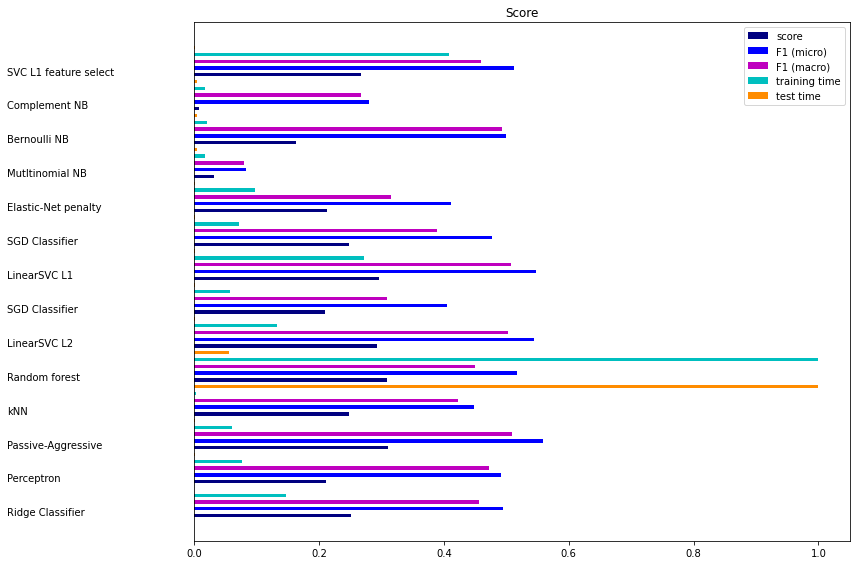

,Score,F1 micro,F1 macro,Training time,Testing time
Ridge Classifier,0.250398,0.493955,0.455529,2.445163,0.002867
Perceptron,0.211437,0.491479,0.472884,1.259131,0.024684
Passive-Aggressive,0.310297,0.559196,0.509434,1.000540,0.009714
kNN,0.248012,0.448483,0.422292,0.051955,20.866526
Random forest,0.307978,0.516489,0.450219,16.613768,1.161453
LinearSVC L2,0.292937,0.543465,0.502656,2.189169,0.009938
SGD Classifier,0.208654,0.404518,0.308368,0.961122,0.009180
LinearSVC L1,0.295521,0.548138,0.507160,4.519627,0.009885
SGD Classifier,0.247880,0.477601,0.389154,1.189843,0.009376
Elastic-Net penalty,0.212430,0.411283,0.315061,1.608945,0.009165


Best score algorithm:
Passive-Aggressive: 0.3102968460111317
________________________________________________________________________________
Best f1 micro algorithm:
Passive-Aggressive: 0.5591964337405199
________________________________________________________________________________
Best f1 macro algorithm:
Passive-Aggressive: 0.5094344767004182
________________________________________________________________________________
Fastest training algorithm:
kNN: 0.05195474624633789
________________________________________________________________________________
Fastest testing algorithm:
Ridge Classifier: 0.0028672218322753906
________________________________________________________________________________


In [167]:
evaluate_models(lem_tokens.map(lambda x: ' '.join(x)), dataset['Tags'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset['Body'], dataset['Tags'], test_size=0.2)
mlb = MultiLabelBinarizer().fit(dataset['Tags'].to_list())
y_train = mlb.transform(y_train)
y_test = mlb.transform(y_test)
target_names = mlb.classes_
    

In [192]:
model = Pipeline([
    ('preprocessing', get_preprocessing_pipeline(500)),
    ('linearSVC', OneVsRestClassifier(LinearSVC(penalty='l1', dual=False,
                                           tol=1e-3, random_state=5), n_jobs=-1))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
metrics.f1_score(y_test, y_pred, average='macro')

0.5007867739406039

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
    
pipe = Pipeline([
    ('preprocessing', get_preprocessing_pipeline(500)),
    ('linearSVC', OneVsRestClassifier(LinearSVC(penalty='l1', dual=False,
                                           random_state=5, max_iter=5000), n_jobs=-1))
])

param_grid = {
    'linearSVC__estimator__C': np.linspace(98, 101, 4),
    'linearSVC__estimator__tol': np.logspace(-4, 0, 5),
    'preprocessing__feature-reduction__k': [1000],#[500, 1000],
    'preprocessing__tf-idf__ngram_range': [(1,1), (1,2)]
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, scoring=make_scorer(metrics.f1_score, average='macro'), error_score='raise', n_jobs=-1)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

0.5747552673640451

In [7]:
print(grid_search.best_estimator_)
print(grid_search.best_params_)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('tf-idf',
                                  TfidfVectorizer(max_df=0.5,
                                                  ngram_range=(1, 2),
                                                  stop_words='english',
                                                  sublinear_tf=True)),
                                 ('feature-reduction',
                                  SelectKBest(k=1000,
                                              score_func=<function chi2 at 0x7fe9546a8ee0>))])),
                ('linearSVC',
                 OneVsRestClassifier(estimator=LinearSVC(C=98.0, dual=False,
                                                         max_iter=5000,
                                                         penalty='l1',
                                                         random_state=5,
                                                         tol=0.01),
                                     n_jobs=-1))])

In [35]:
from sklearn.preprocessing import FunctionTransformer

tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]+')
wnl = WordNetLemmatizer()

lem_pipe = Pipeline([
    ('lemmatize', FunctionTransformer(lambda x: x.str.lower().map(
                                      lambda xx: ' '.join([wnl.lemmatize(w) for w in tokenizer.tokenize(xx)])))),
    ('predict', grid_search.best_estimator_)
])
lem_pipe.fit(X_train, y_train)
lem_pipe.score(X_test, y_test)

0.33090379008746357

Le score avec lemmatization est inférieur au score sans. On peut donc supprimer cette étape

# Export du meilleur modèle entraîné

In [11]:
import joblib
joblib.dump(grid_search.best_estimator_, 'app/backend/pipeline.joblib')

['app/backend/pipeline.joblib']

# Export du MLB pour retrouver les tags

In [ ]:
mlb.inverse_transform

In [12]:
joblib.dump(mlb, 'app/backend/mlb.joblib')

['app/backend/mlb.joblib']